In [124]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

import xlearn as xl

%matplotlib inline

In [2]:
np.random.seed(123)

## Inspeect data (copy from hw1)

In [3]:
%%time 

data = pd.read_csv("../../../data/data.csv", parse_dates=["date_time"])

CPU times: user 30.2 s, sys: 14.8 s, total: 45.1 s
Wall time: 45.1 s


In [4]:
data.columns

Index(['date_time', 'zone_id', 'banner_id', 'oaid_hash', 'campaign_clicks',
       'os_id', 'country_id', 'banner_id0', 'rate0', 'g0', 'coeff_sum0',
       'banner_id1', 'rate1', 'g1', 'coeff_sum1', 'impressions', 'clicks'],
      dtype='object')

In [5]:
data = data[
    ["date_time", "zone_id", "banner_id", "oaid_hash", "campaign_clicks", "os_id", "country_id", "impressions", "clicks"]
]

In [6]:
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1


In [7]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


In [8]:
data.date_time.min(), data.date_time.max()

(Timestamp('2021-09-01 00:02:49'), Timestamp('2021-10-02 23:59:59'))

## Extract day (copy from hw1)

In [9]:
data["day"] = (data.date_time - pd.datetime(2021,9,1)).dt.days

/home/ifled/tmpdir/ipykernel_1010838/813304573.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data["day"] = (data.date_time - pd.datetime(2021,9,1)).dt.days


In [10]:
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1,26
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1,25
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1,25
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1,26
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1,26


In [11]:
data.day.min(), data.day.max()

(0, 31)

<AxesSubplot:>

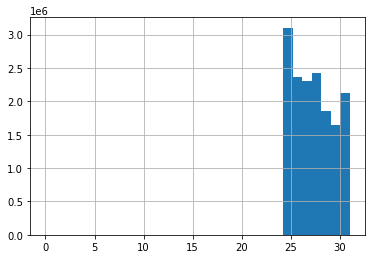

In [12]:
data.day.hist(bins=32)

<AxesSubplot:>

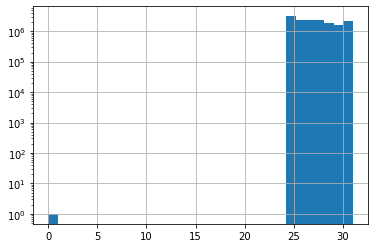

In [13]:
data.day.hist(bins=32, log=True)

In [14]:
data.day.describe()

count    1.582147e+07
mean     2.769505e+01
std      2.039576e+00
min      0.000000e+00
25%      2.600000e+01
50%      2.800000e+01
75%      2.900000e+01
max      3.100000e+01
Name: day, dtype: float64

## There is one outlier:

In [15]:
data[data.day <= 24]

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day
1390198,2021-09-01 00:02:49,30,596,5236744527665721365,0,0,7,1,0,0


## Remove the outlier

In [16]:
data.drop(data[data.day <= 24].index, inplace=True)

In [17]:
data.date_time.min(), data.date_time.max(), data.day.min(), data.day.max()

(Timestamp('2021-09-26 00:00:00'), Timestamp('2021-10-02 23:59:59'), 25, 31)

In [18]:
data.day -= 25

<AxesSubplot:>

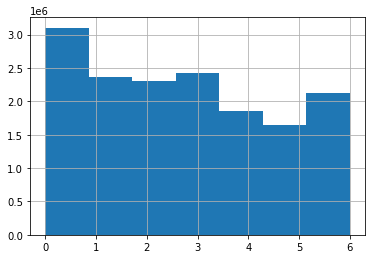

In [19]:
data.day.hist(bins=7)

## Create categorical features to use them later to make datasets in libffm format

In [41]:
data['user_id'] = pd.factorize(data.oaid_hash, sort=True)[0]

In [45]:
columns = ["zone_id", "banner_id", "user_id", "os_id", "country_id"]

In [47]:
cumsum = 0

for colname in columns:
    print(colname, data[colname].min(), data[colname].max())
    data[colname + "_cat"] = data[colname] + cumsum
    cumsum += data[colname].max() + 1

zone_id 0 3443
banner_id 0 1632
user_id 0 6510314
os_id 0 10
country_id 0 16


In [48]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day,user_id,zone_id_cat,banner_id_cat,user_id_cat,os_id_cat,country_id_cat
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821471.0,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07
mean,8.152680e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02,2.695049e+00,3.252650e+06,8.152680e+01,3.825648e+03,3.257727e+06,6.515394e+06,6.515407e+06
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01,2.039565e+00,1.879806e+06,1.632448e+02,3.959386e+02,1.879806e+06,1.530005e+00,4.317701e+00
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.444000e+03,5.077000e+03,6.515392e+06,6.515403e+06
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00,1.621612e+06,1.400000e+01,3.496000e+03,1.626690e+06,6.515393e+06,6.515403e+06
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00,3.000000e+00,3.254090e+06,1.900000e+01,3.661000e+03,3.259167e+06,6.515394e+06,6.515407e+06
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00,4.000000e+00,4.878424e+06,6.000000e+01,4.055000e+03,4.883500e+06,6.515395e+06,6.515410e+06
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00,6.000000e+00,6.510314e+06,3.443000e+03,5.076000e+03,6.515391e+06,6.515402e+06,6.515419e+06


## train dev test split

In [49]:
train = data[data.day <= 4]
dev = data[data.day == 5]
test = data[data.day == 6]
test_feats = test.drop("clicks", axis='columns')

len(train), len(dev), len(test), len(test_feats)

(12049045, 1643448, 2128978, 2128978)

In [50]:
test_feats.columns

Index(['date_time', 'zone_id', 'banner_id', 'oaid_hash', 'campaign_clicks',
       'os_id', 'country_id', 'impressions', 'day', 'user_id', 'zone_id_cat',
       'banner_id_cat', 'user_id_cat', 'os_id_cat', 'country_id_cat'],
      dtype='object')

## Prepare data in libffm format

In [56]:
%%time
dev.to_csv('dev.csv')

CPU times: user 11 s, sys: 248 ms, total: 11.3 s
Wall time: 11.3 s


In [58]:
!head dev.csv

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day,user_id,zone_id_cat,banner_id_cat,user_id_cat,os_id_cat,country_id_cat
59,2021-10-01 00:00:31,28,7,492990345605388039,0,6,1,1,1,5,348312,28,3451,353389,6515398,6515404
85,2021-10-01 00:01:00,27,49,3285764467821396365,0,0,0,1,1,5,2316729,27,3493,2321806,6515392,6515403
86,2021-10-01 00:04:29,27,0,8175386138407715203,0,0,0,1,1,5,5769261,27,3444,5774338,6515392,6515403
104,2021-10-01 00:00:54,40,56,1250565564060433108,0,3,0,1,1,5,882213,40,3500,887290,6515395,6515403
106,2021-10-01 00:03:00,1,0,1180914103150185697,0,0,0,1,1,5,833092,1,3444,838169,6515392,6515403
107,2021-10-01 00:05:12,0,7,2864804392504340727,0,4,1,1,1,5,2020447,0,3451,2025524,6515396,6515404
131,2021-10-01 00:01:12,17,67,8474703857463530042,0,4,5,1,1,5,5980198,17,3511,5985275,6515396,6515408
132,2021-10-01 00:02:20,1,68,3589414614258134560,3,4,4,1,1,5,2531734,1,3512,2536811,6515396,6515407
133,2021-10-01 00:02:49,21,21,31519094

In [59]:
%%time
train.to_csv('train.csv')

CPU times: user 1min 19s, sys: 1.44 s, total: 1min 20s
Wall time: 1min 21s


In [60]:
!head train.csv

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day,user_id,zone_id_cat,banner_id_cat,user_id_cat,os_id_cat,country_id_cat
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1,1,3995054,0,3444,4000131,6515392,6515403
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1,0,3658117,1,3445,3663194,6515392,6515404
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1,0,1563002,2,3446,1568079,6515392,6515403
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1,1,4418225,3,3447,4423302,6515393,6515404
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1,1,3370227,4,3448,3375304,6515393,6515403
5,2021-09-27 00:06:50,5,5,2377014068362699676,0,2,2,1,1,1,1676671,5,3449,1681748,6515394,6515405
6,2021-09-27 00:07:34,6,6,6863358899511896876,0,3,0,1,1,1,4842059,6,3450,4847136,6515395,6515403
7,2021-09-27 00:08:49,7,7,2876502170484631685,0,4,1,1,1,1,2028726,7,3451,2033803,6515396,6515404
8,2021-09-27 00:09:08,8,8,5839858970958967275,0,4,3,1,1,1,

In [61]:
%%time
test.to_csv('test.csv')

CPU times: user 14.7 s, sys: 268 ms, total: 15 s
Wall time: 15 s


In [62]:
!head test.csv

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,day,user_id,zone_id_cat,banner_id_cat,user_id_cat,os_id_cat,country_id_cat
164,2021-10-02 00:01:07,8,76,8008530729166508034,0,1,3,1,1,6,5650808,8,3520,5655885,6515393,6515406
166,2021-10-02 00:00:56,14,46,6788111278352924668,0,6,0,1,1,6,4788929,14,3490,4794006,6515398,6515403
168,2021-10-02 00:04:05,30,76,4080945494333051894,0,2,3,1,1,6,2878122,30,3520,2883199,6515394,6515406
169,2021-10-02 00:04:12,14,46,5180296235094691109,0,0,0,1,1,6,3653701,14,3490,3658778,6515392,6515403
359,2021-10-02 00:01:09,14,2,4843044827996727497,0,0,0,1,1,6,3415627,14,3446,3420704,6515392,6515403
361,2021-10-02 00:02:34,55,131,7553975436848867369,0,1,7,1,1,6,5330220,55,3575,5335297,6515393,6515410
362,2021-10-02 00:03:24,86,84,2874462738663473300,0,3,0,1,1,6,2027282,86,3528,2032359,6515395,6515403
363,2021-10-02 00:04:09,14,46,8874462387033984159,0,0,0,1,1,6,6262998,14,3490,6268075,6515392,6515403
364,2021-10-02 00:04

In [63]:
%%time
test_feats.to_csv('test_feats.csv')

CPU times: user 13.8 s, sys: 264 ms, total: 14.1 s
Wall time: 14.1 s


In [64]:
!head test_feats.csv

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,day,user_id,zone_id_cat,banner_id_cat,user_id_cat,os_id_cat,country_id_cat
164,2021-10-02 00:01:07,8,76,8008530729166508034,0,1,3,1,6,5650808,8,3520,5655885,6515393,6515406
166,2021-10-02 00:00:56,14,46,6788111278352924668,0,6,0,1,6,4788929,14,3490,4794006,6515398,6515403
168,2021-10-02 00:04:05,30,76,4080945494333051894,0,2,3,1,6,2878122,30,3520,2883199,6515394,6515406
169,2021-10-02 00:04:12,14,46,5180296235094691109,0,0,0,1,6,3653701,14,3490,3658778,6515392,6515403
359,2021-10-02 00:01:09,14,2,4843044827996727497,0,0,0,1,6,3415627,14,3446,3420704,6515392,6515403
361,2021-10-02 00:02:34,55,131,7553975436848867369,0,1,7,1,6,5330220,55,3575,5335297,6515393,6515410
362,2021-10-02 00:03:24,86,84,2874462738663473300,0,3,0,1,6,2027282,86,3528,2032359,6515395,6515403
363,2021-10-02 00:04:09,14,46,8874462387033984159,0,0,0,1,6,6262998,14,3490,6268075,6515392,6515403
364,2021-10-02 00:04:39,14,46,3033856779032

In [78]:
!head train.csv | awk -F ',' '{printf("%s 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $10, $13, $14, $15, $16, $17)}'

clicks 0:zone_id_cat:1 1:banner_id_cat:1 2:user_id_cat:1 3:os_id_cat:1 4:country_id_cat:1
1 0:0:1 1:3444:1 2:4000131:1 3:6515392:1 4:6515403:1
1 0:1:1 1:3445:1 2:3663194:1 3:6515392:1 4:6515404:1
1 0:2:1 1:3446:1 2:1568079:1 3:6515392:1 4:6515403:1
1 0:3:1 1:3447:1 2:4423302:1 3:6515393:1 4:6515404:1
1 0:4:1 1:3448:1 2:3375304:1 3:6515393:1 4:6515403:1
1 0:5:1 1:3449:1 2:1681748:1 3:6515394:1 4:6515405:1
1 0:6:1 1:3450:1 2:4847136:1 3:6515395:1 4:6515403:1
1 0:7:1 1:3451:1 2:2033803:1 3:6515396:1 4:6515404:1
1 0:8:1 1:3452:1 2:4124019:1 3:6515396:1 4:6515406:1


In [82]:
!head train.csv | tail -n +2 | awk -F ',' '{printf("%s 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $10, $13, $14, $15, $16, $17)}'

1 0:0:1 1:3444:1 2:4000131:1 3:6515392:1 4:6515403:1
1 0:1:1 1:3445:1 2:3663194:1 3:6515392:1 4:6515404:1
1 0:2:1 1:3446:1 2:1568079:1 3:6515392:1 4:6515403:1
1 0:3:1 1:3447:1 2:4423302:1 3:6515393:1 4:6515404:1
1 0:4:1 1:3448:1 2:3375304:1 3:6515393:1 4:6515403:1
1 0:5:1 1:3449:1 2:1681748:1 3:6515394:1 4:6515405:1
1 0:6:1 1:3450:1 2:4847136:1 3:6515395:1 4:6515403:1
1 0:7:1 1:3451:1 2:2033803:1 3:6515396:1 4:6515404:1
1 0:8:1 1:3452:1 2:4124019:1 3:6515396:1 4:6515406:1


In [83]:
%%time

!cat dev.csv | tail -n +2 | awk -F ',' '{printf("%s 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $10, $13, $14, $15, $16, $17)}' > dev.txt

CPU times: user 56 ms, sys: 56 ms, total: 112 ms
Wall time: 5.72 s


In [84]:
!head dev.txt

1 0:28:1 1:3451:1 2:353389:1 3:6515398:1 4:6515404:1
1 0:27:1 1:3493:1 2:2321806:1 3:6515392:1 4:6515403:1
1 0:27:1 1:3444:1 2:5774338:1 3:6515392:1 4:6515403:1
1 0:40:1 1:3500:1 2:887290:1 3:6515395:1 4:6515403:1
1 0:1:1 1:3444:1 2:838169:1 3:6515392:1 4:6515403:1
1 0:0:1 1:3451:1 2:2025524:1 3:6515396:1 4:6515404:1
1 0:17:1 1:3511:1 2:5985275:1 3:6515396:1 4:6515408:1
1 0:1:1 1:3512:1 2:2536811:1 3:6515396:1 4:6515407:1
1 0:21:1 1:3465:1 2:2227814:1 3:6515392:1 4:6515403:1
1 0:47:1 1:3516:1 2:402735:1 3:6515395:1 4:6515414:1


In [85]:
%%time

!cat train.csv | tail -n +2 | awk -F ',' '{printf("%s 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $10, $13, $14, $15, $16, $17)}' > train.txt

CPU times: user 372 ms, sys: 156 ms, total: 528 ms
Wall time: 40.3 s


In [86]:
!head train.txt

1 0:0:1 1:3444:1 2:4000131:1 3:6515392:1 4:6515403:1
1 0:1:1 1:3445:1 2:3663194:1 3:6515392:1 4:6515404:1
1 0:2:1 1:3446:1 2:1568079:1 3:6515392:1 4:6515403:1
1 0:3:1 1:3447:1 2:4423302:1 3:6515393:1 4:6515404:1
1 0:4:1 1:3448:1 2:3375304:1 3:6515393:1 4:6515403:1
1 0:5:1 1:3449:1 2:1681748:1 3:6515394:1 4:6515405:1
1 0:6:1 1:3450:1 2:4847136:1 3:6515395:1 4:6515403:1
1 0:7:1 1:3451:1 2:2033803:1 3:6515396:1 4:6515404:1
1 0:8:1 1:3452:1 2:4124019:1 3:6515396:1 4:6515406:1
1 0:1:1 1:3453:1 2:3438760:1 3:6515396:1 4:6515407:1


In [87]:
%%time

!cat test.csv | tail -n +2 | awk -F ',' '{printf("%s 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $10, $13, $14, $15, $16, $17)}' > test.txt

CPU times: user 96 ms, sys: 44 ms, total: 140 ms
Wall time: 7.97 s


In [88]:
!head test.txt

1 0:8:1 1:3520:1 2:5655885:1 3:6515393:1 4:6515406:1
1 0:14:1 1:3490:1 2:4794006:1 3:6515398:1 4:6515403:1
1 0:30:1 1:3520:1 2:2883199:1 3:6515394:1 4:6515406:1
1 0:14:1 1:3490:1 2:3658778:1 3:6515392:1 4:6515403:1
1 0:14:1 1:3446:1 2:3420704:1 3:6515392:1 4:6515403:1
1 0:55:1 1:3575:1 2:5335297:1 3:6515393:1 4:6515410:1
1 0:86:1 1:3528:1 2:2032359:1 3:6515395:1 4:6515403:1
1 0:14:1 1:3490:1 2:6268075:1 3:6515392:1 4:6515403:1
1 0:14:1 1:3490:1 2:2144771:1 3:6515392:1 4:6515403:1
1 0:32:1 1:3520:1 2:741379:1 3:6515394:1 4:6515406:1


In [93]:
%%time

!cat test_feats.csv | tail -n +2 | awk -F ',' '{printf("2 0:%s:1 1:%s:1 2:%s:1 3:%s:1 4:%s:1\n", $12, $13, $14, $15, $16)}' > test_feats.txt

CPU times: user 76 ms, sys: 64 ms, total: 140 ms
Wall time: 7.79 s


In [95]:
!head test_feats.txt

2 0:8:1 1:3520:1 2:5655885:1 3:6515393:1 4:6515406:1
2 0:14:1 1:3490:1 2:4794006:1 3:6515398:1 4:6515403:1
2 0:30:1 1:3520:1 2:2883199:1 3:6515394:1 4:6515406:1
2 0:14:1 1:3490:1 2:3658778:1 3:6515392:1 4:6515403:1
2 0:14:1 1:3446:1 2:3420704:1 3:6515392:1 4:6515403:1
2 0:55:1 1:3575:1 2:5335297:1 3:6515393:1 4:6515410:1
2 0:86:1 1:3528:1 2:2032359:1 3:6515395:1 4:6515403:1
2 0:14:1 1:3490:1 2:6268075:1 3:6515392:1 4:6515403:1
2 0:14:1 1:3490:1 2:2144771:1 3:6515392:1 4:6515403:1
2 0:32:1 1:3520:1 2:741379:1 3:6515394:1 4:6515406:1


In [97]:
%%time

!cat train.txt | shuf > train_shuffled.txt

CPU times: user 72 ms, sys: 52 ms, total: 124 ms
Wall time: 5.58 s


In [98]:
!head train_shuffled.txt

0 0:682:1 1:3615:1 2:2232330:1 3:6515393:1 4:6515410:1
0 0:1:1 1:3447:1 2:2530321:1 3:6515393:1 4:6515404:1
0 0:12:1 1:3805:1 2:4064251:1 3:6515394:1 4:6515403:1
0 0:12:1 1:3740:1 2:6345964:1 3:6515393:1 4:6515416:1
0 0:31:1 1:4036:1 2:5020146:1 3:6515394:1 4:6515406:1
0 0:16:1 1:4416:1 2:627118:1 3:6515396:1 4:6515418:1
0 0:50:1 1:3462:1 2:362709:1 3:6515396:1 4:6515416:1
0 0:61:1 1:3611:1 2:4974261:1 3:6515394:1 4:6515418:1
0 0:216:1 1:3600:1 2:2619320:1 3:6515393:1 4:6515410:1
0 0:1:1 1:4040:1 2:633021:1 3:6515396:1 4:6515409:1


In [106]:
!head -n 100000 train_shuffled.txt > train_shuffled_100k.txt

In [107]:
!head -n 1000000 train_shuffled.txt > train_shuffled_1M.txt

In [116]:
!shuf dev.txt | head -n 100000 > dev_shuffled_100k.txt

shuf: write error: Broken pipe
shuf: write error


In [117]:
!wc -l *.txt

    100000 dev_shuffled_100k.txt
   1643448 dev.txt
   2128978 test_feats.txt
   2128978 test.txt
    100000 train_shuffled_100k.txt
   1000000 train_shuffled_1M.txt
  12049045 train_shuffled.txt
  12049045 train.txt
  31199494 total


In [118]:
len(train), len(dev), len(test), len(test_feats)

(12049045, 1643448, 2128978, 2128978)

## Prepare baseline

In [119]:
train.clicks.mean(), dev.clicks.mean()

(0.02308797087238034, 0.04180174851896744)

## Predict constant learned from train

In [120]:
metrics.log_loss(dev.clicks, [0.02308797087238034] * len(dev))

0.17990976856673876

In [121]:
metrics.log_loss(test.clicks, [0.02308797087238034] * len(test))

0.15592795520192157

## Predict constant learned from dev

In [122]:
metrics.log_loss(dev.clicks, [0.04180174851896744] * len(dev))

0.1736285268660261

In [123]:
metrics.log_loss(test.clicks, [0.04180174851896744] * len(test))

0.15357188282131304

In [1]:
import xlearn as xl

In [2]:
!mkdir -p models

In [3]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled_100k.txt")
ffm_model.setValidate("./dev_shuffled_100k.txt")

In [4]:
param = {'task':'binary', 'lr':0.2, 'lambda':0.002}
ffm_model.fit(param, "./models/try1.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled_100k.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev_shuffled_100k.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 0.09

In [5]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled_1M.txt")
ffm_model.setValidate("./dev_shuffled_100k.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002}
ffm_model.fit(param, "./models/try2.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled_1M.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev_shuffled_100k.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 0.55 (

In [7]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled_1M.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002}
ffm_model.fit(param, "./models/try3.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled_1M.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 1.29 (sec)
[ ACTION 

In [8]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002}
ffm_model.fit(param, "./models/try4.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.13 (sec)
[ ACTION    

In [9]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':2}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.49 (sec)
[ ACTION    

In [10]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':3}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.32 (sec)
[ ACTION    

In [11]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':4}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.96 (sec)
[ ACTION    

In [12]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':5}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.18 (sec)
[ ACTION    

In [13]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':6}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.40 (sec)
[ ACTION    

In [14]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':10}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 6.98 (sec)
[ ACTION    

In [15]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':20}
ffm_model.fit(param, "./models/try5.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.01 (sec)
[ ACTION    

## Try to predict

In [16]:
ffm_model.setTest("./test_feats.txt")

In [17]:
!mkdir -p outputs

In [20]:
ffm_model.setSigmoid()
ffm_model.predict("./models/try5.out", "./outputs/output_try5.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from ./models/try5.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 6515420
[------------] Number of K: 20
[------------] Number of field: 5
[------------] Time cost for loading model: 3.84 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./test_feats.txt.bin) found. Skip converting text to binary

In [21]:
!head ./outputs/output_try5.txt

0.0288394
0.0770311
0.0182842
0.0635054
0.130568
0.0172705
0.148716
0.0597713
0.0633808
0.0194682


In [22]:
!wc -l ./outputs/output_try5.txt

2128978 ./outputs/output_try5.txt


In [24]:
import pandas as pd

In [25]:
pred = pd.read_csv('./outputs/output_try5.txt', header=None)

In [26]:
pred.shape

(2128978, 1)

In [27]:
pred.head()

,0
0,0.028839
1,0.077031
2,0.018284
3,0.063505
4,0.130568


In [28]:
from sklearn import metrics

In [29]:
test = pd.read_csv('test.csv')

In [30]:
metrics.log_loss(test.clicks, pred)

0.13556394046614476

## Run random search

In [34]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'k':50}
ffm_model.fit(param, "./models/try5.out")

Info: 
 Model: ffm
 Loss: cross-entropy
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for 

In [59]:
import random

In [60]:
random.seed(42)

In [61]:
for i in range(10):
    param = {
        'task':'binary',
        'lr': random.choice([2.0, 1.0, 0.5, 0.2, 0.01, 0.05, 0.02]),
        'lambda': random.choice([0.02, 0.008, 0.004, 0.002, 0.001, 0.0005, 0.0002]),
        'k': random.choice([2, 3, 4, 5, 6, 10, 20, 50])
    }
    print(param)

{'task': 'binary', 'lr': 0.05, 'lambda': 0.02, 'k': 2}
{'task': 'binary', 'lr': 0.05, 'lambda': 0.004, 'k': 5}
{'task': 'binary', 'lr': 1.0, 'lambda': 0.008, 'k': 3}
{'task': 'binary', 'lr': 0.05, 'lambda': 0.0005, 'k': 3}
{'task': 'binary', 'lr': 0.01, 'lambda': 0.002, 'k': 2}
{'task': 'binary', 'lr': 2.0, 'lambda': 0.02, 'k': 5}
{'task': 'binary', 'lr': 1.0, 'lambda': 0.001, 'k': 2}
{'task': 'binary', 'lr': 0.01, 'lambda': 0.008, 'k': 20}
{'task': 'binary', 'lr': 1.0, 'lambda': 0.002, 'k': 6}
{'task': 'binary', 'lr': 0.02, 'lambda': 0.0002, 'k': 2}


In [62]:
random.seed(42)

In [ ]:
for i in range(250):
    param = {
        'task':'binary',
        'lr': random.choice([2.0, 1.0, 0.5, 0.2, 0.01, 0.05, 0.02]),
        'lambda': random.choice([0.02, 0.008, 0.004, 0.002, 0.001, 0.0005, 0.0002]),
        'k': random.choice([2, 3, 4, 5, 6, 10, 20, 50]),
        'epoch': 20,
    }
    print(i, param)
    
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("./train_shuffled.txt")
    ffm_model.setValidate("./dev.txt")
    ffm_model.fit(param, "./models/try6.out")

0 {'task': 'binary', 'lr': 0.05, 'lambda': 0.02, 'k': 2, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.47 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.99 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.099880            0.160788                3.78
[   10%      ]     2            0.092949            0.158688                3.79
[   15%      ]     3            0.088278            0.158340                3.76
[   20%      ]     4            0.084534            0.157320                3.72
[   25%      ]     5            0.0813

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 1.93 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
5[------------] Total time cost: 86.86 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.02, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First chec

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 10.04 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
8[------------] Total time cost: 93.15 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.002, 'k': 6, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting 

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 1.83 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
11[------------] Total time cost: 89.26 (sec)
 {'task': 'binary', 'lr': 0.05, 'lambda': 0.002, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First 

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.04 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.97 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.104259            0.163375                3.66
[   10%      ]     2            0.102561            0.162444                3.77
[   15%      ]     3            0.102091            0.162201                3.77
[   20%      ]     4            0.101777            0.161867                3.72
[   25%      ]     5            0.1015

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.97 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.79 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.106274            0.165330                3.72
[   10%      ]     2            0.103748            0.163987                3.81
[   15%      ]     3            0.103183            0.163321                3.76
[   20%      ]     4            0.102829            0.162921                3.77
[   25%      ]     5            0.1025

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 3.83 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
19[------------] Total time cost: 104.53 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.0005, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convert

[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.57 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.74 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.092708            0.145753                4.33
[   10%      ]     2            0.076534            0.148308                4.01
[   15%      ]     3            0.061554            0.153901                3.98
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.145753
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 3.88 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
22[------------] Total time cost: 27.28 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.004, 'k': 3, '

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.07 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
24[------------] Total time cost: 87.92 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.004, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First c

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.21 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 2.96 GB
[------------] Time cost for model initial: 3.06 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.098475            0.156657                4.72
[   10%      ]     2            0.091036            0.154430                4.96
[   15%      ]     3            0.085774            0.155152                4.84
[   20%      ]     4            0.081331            0.153794                4.84
[   25%      ]     5            0.0774

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.58 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.16 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.104213            0.158911                3.75
[   10%      ]     2            0.101049            0.156555                3.77
[   15%      ]     3            0.100355            0.155504                3.82
[   20%      ]     4            0.099943            0.154832                3.81
[   25%      ]     5            0.0996

[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.097152            0.152727                5.33
[   10%      ]     2            0.088825            0.151216                5.35
[   15%      ]     3            0.082486            0.150119                5.24
[   20%      ]     4            0.076946            0.152327                5.19
[   25%      ]     5            0.072096            0.151726                5.35
[   30%      ]     6            0.067782            0.153069                5.30
[   35%      ]     7            0.063914            0.155648                5.23
[   40%      ]     8            0.060334            0.157822                5.24
[ ACTION     ] Early-stopping at epoch 3, best loss: 0.150119
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 12.88 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environ

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.74 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.91 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.092556            0.143921                3.79
[   10%      ]     2            0.077820            0.145153                3.69
[   15%      ]     3            0.062080            0.150776                3.77
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.143921
[ ACTION     ] Start to save model ...
[------------] Mod

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.60 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
37[------------] Total time cost: 102.45 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.0005, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convert

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 27.27 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
40[------------] Total time cost: 150.47 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.004, 'k': 4, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convertin

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 10.42 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
43[------------] Total time cost: 186.50 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.002, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Firs

[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.89 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.091473            0.145764                3.68
[   10%      ]     2            0.070980            0.147919                3.65
[   15%      ]     3            0.051083            0.163202                3.70
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.145764
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 3.99 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
46[------------] Total time cost: 24.41 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.02, 'k': 4, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ _

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.39 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 4.90 GB
[------------] Time cost for model initial: 5.72 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.108047            0.171456                6.30
[   10%      ]     2            0.106126            0.170852                6.38
[   15%      ]     3            0.105710            0.170772                6.35
[   20%      ]     4            0.105460            0.169670                6.26
[   25%      ]     5            0.1053

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.50 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.00 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.100351            0.153017                3.75
[   10%      ]     2            0.098437            0.151958                3.70
[   15%      ]     3            0.097464            0.151598                3.86
[   20%      ]     4            0.096567            0.150703                3.85
[   25%      ]     5            0.0956

[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.101819            0.155313                5.08
[   10%      ]     2            0.099605            0.153726                4.93
[   15%      ]     3            0.098943            0.153014                4.95
[   20%      ]     4            0.098475            0.152511                5.08
[   25%      ]     5            0.098054            0.152010                5.17
[   30%      ]     6            0.097655            0.151727                5.29
[   35%      ]     7            0.097271            0.151354                5.20
[   40%      ]     8            0.096888            0.151059                4.92
[   45%      ]     9            0.096509            0.150918                5.09
[   50%      ]    10            0.096119            0.150611                5.01
[   55%      ]    11            0.095738            0.150358                5.05
[   60%      ]    12        

[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.43 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 2.05 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.100211            0.153075                4.19
[   10%      ]     2            0.098205            0.151815                4.19
[   15%      ]     3            0.097114            0.151160                4.10
[   20%      ]     4            0.096108            0.150276                4.10
[   25%      ]     5            0.095124            0.149836                4.14
[   30%      ]     6            0.094144            0.149354                4.14
[   35%      ]     7            0.093148            0.148984                4.21
[   40%      ]     8            0.092186            0.14862

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.26 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
59[------------] Total time cost: 64.20 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.0005, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convertin

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.37 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.87 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.104421            0.158723                3.63
[   10%      ]     2            0.100944            0.155911                3.64
[   15%      ]     3            0.100135            0.154627                3.70
[   20%      ]     4            0.099660            0.153947                3.72
[   25%      ]     5            0.0993

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.90 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.97 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.101405            0.153223                4.11
[   10%      ]     2            0.098928            0.152053                4.24
[   15%      ]     3            0.098225            0.151492                4.10
[   20%      ]     4            0.097707            0.151002                4.02
[   25%      ]     5            0.0972

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.07 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
67[------------] Total time cost: 66.96 (sec)
 {'task': 'binary', 'lr': 0.05, 'lambda': 0.002, 'k': 3, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.30 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 12.67 GB
[------------] Time cost for model initial: 14.36 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.094040            0.147578               10.49
[   10%      ]     2            0.082325            0.144849               10.72
[   15%      ]     3            0.071705            0.149276               10.63
[   20%      ]     4            0.061260            0.155433               10.64
[   25%      ]     5            0.05

72[------------] Total time cost: 169.02 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.001, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feat

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 6.81 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
75[------------] Total time cost: 133.99 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.001, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First 

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.30 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
78[------------] Total time cost: 53.67 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.001, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting

[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.40 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.88 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.092794            0.145646                3.68
[   10%      ]     2            0.076551            0.146798                3.62
[   15%      ]     3            0.061558            0.155461                3.63
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.145646
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 1.98 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
81[------------] Total time cost: 22.25 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.02, 'k': 2, 'ep

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.57 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.94 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.107009            0.167618                4.11
[   10%      ]     2            0.104752            0.166686                4.07
[   15%      ]     3            0.104228            0.166222                4.16
[   20%      ]     4            0.103907            0.165907                4.13
[   25%      ]     5            0.1036

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 26.81 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
86[------------] Total time cost: 159.84 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.0002, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convert

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 10.95 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
89[------------] Total time cost: 131.75 (sec)
 {'task': 'binary', 'lr': 0.5, 'lambda': 0.002, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.03 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
92[------------] Total time cost: 89.29 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.002, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First c

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 3.39 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
95 {'task': 'binary', 'lr': 0.01, 'lambda': 0.002, 'k': 4, 'epoch': 20}
[------------] Total time cost: 61.93 (sec)
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.70 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.04 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.102448            0.163237                3.81
[   10%      ]     2            0.100289            0.162374                3.83
[   15%      ]     3            0.098775            0.161656                3.85
[   20%      ]     4            0.097482            0.160954                3.80
[   25%      ]     5            0.0963

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.13 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.76 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.091517            0.146831                4.11
[   10%      ]     2            0.071272            0.148722                4.37
[   15%      ]     3            0.050757            0.162172                4.20
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.146831
[ ACTION     ] Start to save model ...
[------------] Mod

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.00 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 4.90 GB
[------------] Time cost for model initial: 5.49 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.098185            0.157994                6.23
[   10%      ]     2            0.087471            0.158796                6.14
[   15%      ]     3            0.080626            0.157455                6.32
[   20%      ]     4            0.075303            0.160194                6.17
[   25%      ]     5            0.0709

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.32 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 12.67 GB
[------------] Time cost for model initial: 14.34 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.098623            0.154972                7.48
[   10%      ]     2            0.093341            0.153696                7.57
[   15%      ]     3            0.089220            0.151332                7.50
[   20%      ]     4            0.085487            0.151653                7.38
[   25%      ]     5            0.08

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.57 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
109[------------] Total time cost: 87.91 (sec)
 {'task': 'binary', 'lr': 0.05, 'lambda': 0.004, 'k': 2, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convertin

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 3.80 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
112[------------] Total time cost: 90.53 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.001, 'k': 3, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First c

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 5.06 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
115[------------] Total time cost: 66.25 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.02, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting 

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.44 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 4.90 GB
[------------] Time cost for model initial: 5.79 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.107917            0.171481                5.18
[   10%      ]     2            0.106123            0.171142                5.07
[   15%      ]     3            0.105707            0.170452                5.18
[   20%      ]     4            0.105454            0.169111                5.18
[   25%      ]     5            0.1053

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 7.39 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
120[------------] Total time cost: 124.95 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.004, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.07 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
123[------------] Total time cost: 87.93 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.002, 'k': 3, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.09 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.74 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.103357            0.168434                3.95
[   10%      ]     2            0.099372            0.166422                3.97
[   15%      ]     3            0.096635            0.164811                4.02
[   20%      ]     4            0.094436            0.164904                4.04
[   25%      ]     5            0.0925

129[------------] Total time cost: 46.19 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.0002, 'k': 2, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Fe

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.51 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.17 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.105608            0.168961                3.65
[   10%      ]     2            0.104603            0.169146                3.77
[   15%      ]     3            0.104125            0.168471                3.64
[   20%      ]     4            0.103725            0.168783                3.67
[   25%      ]     5            0.1033

[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.100940            0.155797                3.84
[   10%      ]     2            0.099227            0.154741                3.78
[   15%      ]     3            0.098392            0.154028                3.86
[   20%      ]     4            0.097666            0.153755                3.76
[   25%      ]     5            0.096987            0.153220                3.84
[   30%      ]     6            0.096340            0.152860                3.92
[   35%      ]     7            0.095688            0.152350                3.80
[   40%      ]     8            0.095041            0.151922                3.90
[   45%      ]     9            0.094405            0.151621                3.75
[   50%      ]    10            0.093771            0.151419                3.71
[   55%      ]    11            0.093149            0.151199                3.82
[   60%      ]    12        

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.95 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
136[------------] Total time cost: 109.94 (sec)
 {'task': 'binary', 'lr': 0.05, 'lambda': 0.0005, 'k': 6, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Firs

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.11 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.98 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.106712            0.170489                3.88
[   10%      ]     2            0.105460            0.169916                3.88
[   15%      ]     3            0.105090            0.169704                3.90
[   20%      ]     4            0.104865            0.169533                3.96
[   25%      ]     5            0.1046

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 9.08 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
141[------------] Total time cost: 112.71 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.008, 'k': 6, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 15.12 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
144[------------] Total time cost: 164.10 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.02, 'k': 3, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 11.30 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
147[------------] Total time cost: 74.16 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.001, 'k': 4, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.96 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.89 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.099907            0.158360                3.83
[   10%      ]     2            0.095303            0.155721                3.94
[   15%      ]     3            0.091942            0.156174                3.97
[   20%      ]     4            0.089086            0.155126                3.84
[   25%      ]     5            0.0865

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 8.13 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
152[------------] Total time cost: 131.12 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.001, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convert

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.93 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.12 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.092378            0.144338                3.78
[   10%      ]     2            0.077255            0.145503                3.68
[   15%      ]     3            0.061146            0.154073                3.79
[ ACTION     ] Early-stopping at epoch 1, best loss: 0.144338
[ ACTION     ] Start to save model ...
[------------] Mod

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.55 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
157[------------] Total time cost: 92.54 (sec)
 {'task': 'binary', 'lr': 0.05, 'lambda': 0.004, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.06 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 1.01 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.101237            0.161983                3.61
[   10%      ]     2            0.096976            0.160382                3.64
[   15%      ]     3            0.093949            0.159678                3.64
[   20%      ]     4            0.091461            0.158674                3.66
[   25%      ]     5            0.0893

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.80 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
162[------------] Total time cost: 108.17 (sec)
 {'task': 'binary', 'lr': 1.0, 'lambda': 0.0002, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Firs

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.78 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
165[------------] Total time cost: 101.34 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.004, 'k': 6, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip convertin

[------------] Model size: 4.90 GB
[------------] Time cost for model initial: 5.75 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.095652            0.148844                5.38
[   10%      ]     2            0.087470            0.145989                5.44
[   15%      ]     3            0.080265            0.145280                5.25
[   20%      ]     4            0.073308            0.147499                5.51
[   25%      ]     5            0.066525            0.150273                5.36
[   30%      ]     6            0.059978            0.154128                5.51
[ ACTION     ] Early-stopping at epoch 3, best loss: 0.145280
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 11.92 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
168[------------] Total time 

[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.095582            0.152096                4.55
[   10%      ]     2            0.085919            0.146982                4.34
[   15%      ]     3            0.078006            0.147838                4.14
[   20%      ]     4            0.070813            0.150994                4.04
[   25%      ]     5            0.064188            0.154693                4.56
[ ACTION     ] Early-stopping at epoch 2, best loss: 0.146982
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 5.11 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
171[------------] Total time cost: 39.75 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.02, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          |

[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.99 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.099018            0.153607                3.74
[   10%      ]     2            0.095778            0.151881                3.82
[   15%      ]     3            0.093096            0.151072                3.76
[   20%      ]     4            0.090648            0.149890                3.76
[   25%      ]     5            0.088291            0.149422                3.69
[   30%      ]     6            0.086043            0.148516                3.78
[   35%      ]     7            0.083918            0.148740                3.83
[   40%      ]     8            0.081891            0.147703                3.75
[   45%      ]     9            0.079961            0.147748                3.83
[   50%      ]    10            0.078112            0.147989      

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 12.03 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
176[------------] Total time cost: 148.96 (sec)
 {'task': 'binary', 'lr': 2.0, 'lambda': 0.001, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 7.26 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
179 {'task': 'binary', 'lr': 0.05, 'lambda': 0.0002, 'k': 3, 'epoch': 20}
[------------] Total time cost: 132.19 (sec)
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Firs

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.66 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 2.96 GB
[------------] Time cost for model initial: 3.13 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.101664            0.158730                4.90
[   10%      ]     2            0.100171            0.157993                4.84
[   15%      ]     3            0.099485            0.157822                4.73
[   20%      ]     4            0.098908            0.156952                4.78
[   25%      ]     5            0.0983

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.94 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
184[------------] Total time cost: 55.90 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.0005, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converti

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 4.74 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
187[------------] Total time cost: 109.63 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.001, 'k': 2, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First 

[------------] Model size: 2.96 GB
[------------] Time cost for model initial: 3.08 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.096515            0.147841                4.58
[   10%      ]     2            0.090202            0.145145                4.47
[   15%      ]     3            0.084202            0.143774                4.59
[   20%      ]     4            0.077897            0.143512                4.66
[   25%      ]     5            0.071454            0.144008                4.65
[   30%      ]     6            0.065020            0.146970                4.64
[   35%      ]     7            0.058911            0.149585                4.57
[ ACTION     ] Early-stopping at epoch 4, best loss: 0.143512
[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 7.48 (sec)
[ ACTION     ] Finish traini

192[------------] Total time cost: 323.88 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.0002, 'k': 4, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of F

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.27 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 2.96 GB
[------------] Time cost for model initial: 3.17 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.103629            0.157836                4.91
[   10%      ]     2            0.100686            0.155671                4.58
[   15%      ]     3            0.100043            0.154702                4.53
[   20%      ]     4            0.099663            0.154049                4.51
[   25%      ]     5            0.0993

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 5.59 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
197[------------] Total time cost: 107.39 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.008, 'k': 4, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First

[ ACTION     ] Start to save model ...
[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.97 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
200[------------] Total time cost: 64.21 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.002, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.51 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.79 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.100021            0.156404                4.35
[   10%      ]     2            0.097362            0.155877                4.47
[   15%      ]     3            0.095312            0.154063                4.36
[   20%      ]     4            0.093415            0.153987                4.44
[   25%      ]     5            0.0916

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.65 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
205[------------] Total time cost: 91.46 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.002, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First 

208[------------] Total time cost: 30.38 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.02, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Fea

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 9.29 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
211[------------] Total time cost: 136.24 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.002, 'k': 20, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Firs

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.34 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 12.67 GB
[------------] Time cost for model initial: 14.44 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.094026            0.147115                7.57
[   10%      ]     2            0.082347            0.146105                7.64
[   15%      ]     3            0.071803            0.149171                7.60
[   20%      ]     4            0.061386            0.156062                7.66
[   25%      ]     5            0.05

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 5.38 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
216[------------] Total time cost: 110.65 (sec)
 {'task': 'binary', 'lr': 0.02, 'lambda': 0.0002, 'k': 50, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Fir

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.10 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.97 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.104469            0.168072                4.10
[   10%      ]     2            0.102481            0.167921                4.18
[   15%      ]     3            0.101077            0.166818                4.25
[   20%      ]     4            0.099904            0.166773                4.19
[   25%      ]     5            0.0988

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.33 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.99 GB
[------------] Time cost for model initial: 1.78 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.099881            0.159969                4.15
[   10%      ]     2            0.092937            0.158275                4.22
[   15%      ]     3            0.088284            0.158381                4.36
[   20%      ]     4            0.084534            0.157784                4.13
[   25%      ]     5            0.0813

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 2.56 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
224[------------] Total time cost: 91.25 (sec)
 {'task': 'binary', 'lr': 0.2, 'lambda': 0.002, 'k': 10, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First 

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.24 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 4.90 GB
[------------] Time cost for model initial: 5.69 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.098166            0.158593                6.35
[   10%      ]     2            0.087467            0.156229                6.36
[   15%      ]     3            0.080632            0.157371                6.39
[   20%      ]     4            0.075301            0.157174                6.31
[   25%      ]     5            0.0709

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 7.19 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 2.96 GB
[------------] Time cost for model initial: 3.05 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.104475            0.168091                5.33
[   10%      ]     2            0.102473            0.167453                5.47
[   15%      ]     3            0.101071            0.166920                5.08
[   20%      ]     4            0.099907            0.166555                5.49
[   25%      ]     5            0.0988

[------------] Model file: ./models/try6.out
[------------] Time cost for saving model: 11.69 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
232[------------] Total time cost: 160.49 (sec)
 {'task': 'binary', 'lr': 0.01, 'lambda': 0.0005, 'k': 5, 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] Fir

[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.66 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.02 GB
[------------] Time cost for model initial: 0.88 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss     Time cost (sec)
[    5%      ]     1            0.100048            0.156968                3.91
[   10%      ]     2            0.097424            0.155078                3.80
[   15%      ]     3            0.095453            0.154294                3.80
[   20%      ]     4            0.093648            0.154174                3.91
[   25%      ]     5            0.0919

### Unofortunately last 15 outputs were lost

## the best dev loss is 0.142929 (find out that by manually inspecting all outputs), it was obtained on launch #15, retrain that model and calculate score on test set

In [3]:
import xlearn as xl

In [5]:
param = {'task': 'binary', 'lr': 0.5, 'lambda': 0.0002, 'k': 10, 'epoch': 20}
ffm_model = xl.create_ffm()
ffm_model.setTrain("./train_shuffled.txt")
ffm_model.setValidate("./dev.txt")
ffm_model.fit(param, "./models/try7.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./train_shuffled.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./dev.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6515420
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.31 (sec)
[ ACTION    

In [6]:
ffm_model.setTest("./test_feats.txt")
ffm_model.setSigmoid()
ffm_model.predict("./models/try7.out", "./outputs/output_try7.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 56 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from ./models/try7.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 6515420
[------------] Number of K: 10
[------------] Number of field: 5
[------------] Time cost for loading model: 2.39 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./test_feats.txt.bin) found. Skip converting text to binary

In [7]:
!head ./outputs/output_try7.txt

0.019583
0.122294
0.0147178
0.0511979
0.145217
0.0157662
0.47128
0.0586933
0.0589227
0.0143597


In [8]:
!wc -l ./outputs/output_try7.txt

2128978 ./outputs/output_try7.txt


In [11]:
import pandas as pd
pred = pd.read_csv('./outputs/output_try7.txt', header=None)
pred.shape

(2128978, 1)

In [12]:
pred.head()

,0
0,0.019583
1,0.122294
2,0.014718
3,0.051198
4,0.145217


In [13]:
from sklearn import metrics
test = pd.read_csv('test.csv')
metrics.log_loss(test.clicks, pred)

0.12978548826342526

## Results

| method | log loss on the last day |
|------|------|
| linear model (banner_id as features) | 0.15602 |
| **baseline** | 0.15357|
| linear model (several features) | 0.13598 |
| linear model (several features + interactions) | 0.13583 |
| ffm (almost not tuned, k=20) | 0.13556 |
| **ffm (tuned, k=10)** | 0.12979 |

Note:
- linear models were not almost tuned, there was just some feature engineering, so probably quality may be improved
- I was not able to find what embedding size better suites: there are several launches that have dev log loss around 0.143 and have different embedding sizes

## The following is just copy from hw1 (contains log loss for linear models):

## Clicks depend on banner_id:

<AxesSubplot:>

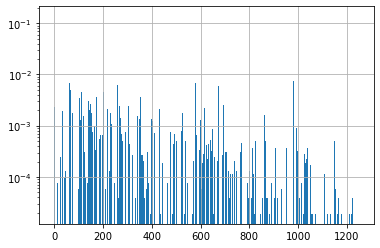

In [29]:
dev[dev.clicks == 1].banner_id.hist(bins=1633, density=True, log=True)

<AxesSubplot:>

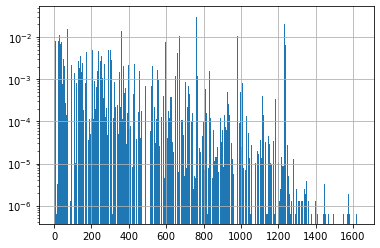

In [30]:
dev[dev.clicks == 0].banner_id.hist(bins=1633, density=True, log=True)

## Predict separate constant for each banner_id

In [31]:
banner_id2clicks = train.groupby("banner_id").clicks.mean()

In [32]:
# predict average click ratio for unknown banner_id
banner_id2clicks[banner_id2clicks.isna()] = 0.04180174851896744

## Better for dev but worse for test

In [33]:
metrics.log_loss(
    dev.clicks,
    dev.join(banner_id2clicks, on="banner_id", rsuffix="_banner_id").clicks_banner_id
)

0.1635688979134283

In [34]:
metrics.log_loss(
    test.clicks,
    test_feats.join(banner_id2clicks, on='banner_id').clicks
)

0.1560167297399033

## Apply logistic regression with liblinear optimizer for 'zone_id', 'banner_id', 'os_id', 'country_id'

In [35]:
categorical_columns

['zone_id', 'banner_id', 'os_id', 'country_id']

In [36]:
X_train_cat = train[categorical_columns].to_numpy()

In [37]:
ohe = preprocessing.OneHotEncoder(categories=[range(3444), range(1633), range(11), range(17)])

In [38]:
ohe.fit(X_train_cat)

OneHotEncoder(categories=[range(0, 3444), range(0, 1633), range(0, 11),
                          range(0, 17)])

In [39]:
X_train = ohe.transform(X_train_cat)

In [40]:
X_train.shape

(12049045, 5105)

In [41]:
model = linear_model.LogisticRegression(solver='liblinear')

In [42]:
shuffled_train_idxs = list(range(len(train)))
np.random.shuffle(shuffled_train_idxs)

In [43]:
%%time
model.fit(X_train[shuffled_train_idxs[:2000000]], train.clicks.to_numpy()[shuffled_train_idxs[:2000000]])

CPU times: user 1min 25s, sys: 3.25 s, total: 1min 29s
Wall time: 34.1 s


LogisticRegression(solver='liblinear')

In [44]:
X_dev = ohe.transform(dev[categorical_columns].to_numpy())

In [45]:
%%time
dev_predict = model.predict_proba(X_dev)

CPU times: user 59.8 ms, sys: 15.6 ms, total: 75.4 ms
Wall time: 72.1 ms


In [46]:
metrics.log_loss(dev.clicks, dev_predict)

0.15287545717148104

In [47]:
X_test = ohe.transform(test_feats[categorical_columns].to_numpy())
test_predict = model.predict_proba(X_test)
metrics.log_loss(test.clicks, test_predict)

0.13597807111968535

## Apply logistic regression with liblinear optimizer for 'zone_id', 'banner_id', 'os_id', 'country_id', regularization and interactions banner_Id : os_id and banner_id : country_id

In [48]:
def make_features_with_interactions(df):
    feats = np.zeros((df.shape[0], 6))
    feats[:, :4] = df[categorical_columns].to_numpy()
    
    # interaction banner_id (idx=1, cnt=1633) x os_id (idx=2, cnt=11)
    feats[:, 4] = feats[:, 1] * 11 + feats[:, 2]
    
    # interaction banner_id (idx=1, cnt=1633) x country_id (idx=3, cnt=17)
    feats[:, 5] = feats[:, 1] * 17 + feats[:, 3]
    
    return feats

In [49]:
%%time
X_train_cat_with_interactions = make_features_with_interactions(train)

CPU times: user 1.06 s, sys: 724 ms, total: 1.78 s
Wall time: 1.78 s


In [50]:
X_train_cat_with_interactions[:10]

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   0.,   1.,  11.,  18.],
       [  2.,   2.,   0.,   0.,  22.,  34.],
       [  3.,   3.,   1.,   1.,  34.,  52.],
       [  4.,   4.,   1.,   0.,  45.,  68.],
       [  5.,   5.,   2.,   2.,  57.,  87.],
       [  6.,   6.,   3.,   0.,  69., 102.],
       [  7.,   7.,   4.,   1.,  81., 120.],
       [  8.,   8.,   4.,   3.,  92., 139.],
       [  1.,   9.,   4.,   4., 103., 157.]])

In [51]:
ohe = preprocessing.OneHotEncoder(
    categories=[range(3444), range(1633), range(11), range(17), range(1633 * 11), range(1633 * 17)]
)

In [52]:
ohe.fit(X_train_cat_with_interactions)

OneHotEncoder(categories=[range(0, 3444), range(0, 1633), range(0, 11),
                          range(0, 17), range(0, 17963), range(0, 27761)])

In [53]:
X_train_wi = ohe.transform(X_train_cat_with_interactions)

In [54]:
model = linear_model.LogisticRegression(solver='liblinear', C=0.3)

In [55]:
%%time
model.fit(X_train_wi[shuffled_train_idxs[:2000000]], train.clicks.to_numpy()[shuffled_train_idxs[:2000000]])

CPU times: user 12min 39s, sys: 44.3 s, total: 13min 23s
Wall time: 38.6 s


LogisticRegression(C=0.3, solver='liblinear')

In [56]:
%%time
dev_predict = model.predict_proba(ohe.transform(make_features_with_interactions(dev)))

CPU times: user 3.19 s, sys: 314 ms, total: 3.5 s
Wall time: 2.08 s


In [57]:
metrics.log_loss(dev.clicks, dev_predict)

0.15271435387517487

In [58]:
test_predict = model.predict_proba(ohe.transform(make_features_with_interactions(test_feats)))
metrics.log_loss(test.clicks, test_predict)

0.1358300575329168